In [1]:
"""
Example script demonstrating the portfolio optimization and backtesting system.

This script shows how to:
1. Load data from CSV files
2. Create and configure optimization strategies
3. Run backtests
4. Compare strategy performance
5. Generate reports and visualizations
"""

import pandas as pd
import numpy as np
from datetime import datetime
import tempfile
import os
from pathlib import Path

# Import our modules
from optfolio.data.loader import DataLoader
from optfolio.data.validator import DataValidator
from optfolio.backtesting.engine import Backtester
from optfolio.strategies.base import StrategyFactory

In [3]:
data_dir = "price"

# Step 2: Load and validate data
print("\n1. Loading and validating data...")
data_loader = DataLoader(data_dir)
sectors = [
        "XLE", "XLF", "XLU", "XLI", "GDX", "XLK", "XLV", "XLY", "XLP", "XLB",
        "XOP", "IYR", "XHB", "ITB", "VNQ", "GDXJ", "IYE", "OIH", "XME", "XRT",
        "SMH", "IBB", "KBE", "KRE", "XTL"
    ]
sectors = ['WSM', 'PAYX', 'BMI', 'BK', 'NDAQ', 'MSI', 'WMT', 'TJX', 'AIG', 'RJF', 'V', 'CTAS', 'TT', 'TRGP', 'JPM', 'GE', 'MCK', 'PH', 'LLY', 'COST', 'AVGO', 'NEE', 'AMAT', 'ADI', 'SHW', 'INTU', 'KLAC']
# Load all available data
prices = data_loader.load_prices(tickers=sectors)
returns = data_loader.get_returns()

print(f"   Loaded {len(prices.columns)} tickers")
print(prices.columns)
print(f"   Date range: {prices.index.min()} to {prices.index.max()}")
print(f"   Total observations: {len(prices)}")

# Validate data
validator = DataValidator()
price_issues = validator.validate_price_data(prices)
returns_issues = validator.validate_returns_data(returns)

print(f"   Data quality score: {validator.get_data_quality_score(prices):.3f}")

if price_issues['warnings']:
    print(f"   Warnings: {len(price_issues['warnings'])}")
if price_issues['errors']:
    print(f"   Errors: {len(price_issues['errors'])}")


1. Loading and validating data...


Loading price data: 100%|██████████| 27/27 [00:00<00:00, 687.71it/s]

   Loaded 27 tickers
Index(['V', 'MSI', 'ADI', 'LLY', 'COST', 'TJX', 'INTU', 'NEE', 'CTAS', 'SHW',
       'AMAT', 'KLAC', 'NDAQ', 'WSM', 'GE', 'TRGP', 'JPM', 'PH', 'MCK', 'PAYX',
       'AVGO', 'BK', 'RJF', 'BMI', 'AIG', 'TT', 'WMT'],
      dtype='object')
   Date range: 2015-08-26 00:00:00 to 2025-08-25 00:00:00
   Total observations: 2514
   Data quality score: 1.000
   Warnings: 1


In [4]:
print("\n2. Creating optimization strategies...")

strategies = [
    StrategyFactory.create('equal_weight'),
    StrategyFactory.create('mean_variance', objective="sortino_ratio"),
    StrategyFactory.create('mean_variance', objective="sharpe_ratio"),
    StrategyFactory.create('random_weight', distribution="dirichlet", seed=42),
    StrategyFactory.create('black_litterman', 
                            prior_method="market_cap", view_method="momentum")
]

strategy_names = ["Equal Weight", "Mean-Variance (Sortino)", "Mean-Variance (Sharpe)", "Random Weight", "Black-Litterman"]
for i, strategy in enumerate(strategies):
    strategy.name = strategy_names[i]
    print(f"   Created: {strategy}")


2. Creating optimization strategies...
   Created: Equal Weight Strategy (Equal Weight)
   Created: Mean-Variance (Sortino) Strategy (sortino_ratio)
   Created: Mean-Variance (Sharpe) Strategy (sharpe_ratio)
   Created: Random Weight Strategy (dirichlet)
   Created: Black-Litterman Strategy (market_cap priors, momentum views)


In [5]:
# Step 4: Set up backtesting
print("\n3. Setting up backtesting...")

backtester = Backtester(
    initial_capital=100000.0,
    risk_free_rate=0.02,
    transaction_costs=0.001
)

# Load data into backtester
backtester.load_data(data_loader, tickers=sectors)


3. Setting up backtesting...


Loading price data: 100%|██████████| 27/27 [00:00<00:00, 598.50it/s]

Loaded data for 27 tickers
Date range: 2015-08-26 00:00:00 to 2025-08-25 00:00:00
Total observations: 2514


In [6]:
# Step 5: Run backtests
print("\n4. Running backtests...")

# Define rebalancing schedule (every 3 months, 1st week, 1st day)
rebalance_freq = {"months": 3, "weeks": 1, "days": 1}

# Run backtests for all strategies
results = backtester.run_multiple_backtests(
    strategies=strategies,
    rebalance_freq=rebalance_freq,
    start_date='2018-01-01',  # Start from 2021 to have enough history
    end_date='2023-12-31'
)

for strategy_name, result in results.items():
    metrics = result['performance_metrics']
    summary = result['summary']
    
    print(f"\n{strategy_name}:")
    print(f"  Total Return: {metrics.get('total_return', 0):.2%}")
    print(f"  Annualized Return: {metrics.get('annualized_return', 0):.2%}")
    print(f"  Volatility: {metrics.get('volatility', 0):.2%}")
    print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.3f}")
    print(f"  Sortino Ratio: {metrics.get('sortino_ratio', 0):.3f}")
    print(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
    print(f"  Number of Transactions: {summary.get('num_transactions', 0)}")
    print(f"  Total Transaction Costs: ${summary.get('total_transaction_costs', 0):.2f}")


4. Running backtests...
Running backtest for Equal Weight
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00
Running backtest for Mean-Variance (Sortino)
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00
Running backtest for Mean-Variance (Sharpe)
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00
Running backtest for Random Weight
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00
Running backtest for Black-Litterman
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00

Equal Weight:
  Total Return: 175.72%
  Annualized Return: 18.74%
  Volatility: 139.55%
  Sharpe Ratio: 3.784
  Sortino Ratio: 9.118
  Max Drawdown: -14.56%
  Number of Transactions: 17
  Total Transaction Costs: $334.17

Mean-Variance (Sortino):
  Total Return: 172.30%
  Annualized Return: 18.49%
  Volatility: 89.79%
  Sharpe Ratio: 5.352
  Sortino Ratio: 10.765
  Max Drawdown: -9.25%
  Num

In [7]:
strategy = StrategyFactory.create('black_litterman', 
                            prior_method="equal", view_method="momentum")
rebalance_freq = {"months": 3}                            
result = backtester.run_backtest(strategy=strategy,rebalance_freq=rebalance_freq,
    start_date='2018-01-01',  # Start from 2021 to have enough history
    end_date='2023-12-31')

Running backtest for black_litterman
Rebalancing dates: 18
Date range: 2018-01-01 00:00:00 to 2023-12-28 00:00:00


In [ ]:
result['rolling_metrics']

In [8]:
metrics = result['performance_metrics']
summary = result['summary']
print(f"\n{strategy}:")
print(f"  Total Return: {metrics.get('total_return', 0):.2%}")
print(f"  Annualized Return: {metrics.get('annualized_return', 0):.2%}")
print(f"  Volatility: {metrics.get('volatility', 0):.2%}")
print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.3f}")
print(f"  Sortino Ratio: {metrics.get('sortino_ratio', 0):.3f}")
print(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
print(f"Summary: {result['summary']}")


black_litterman Strategy (equal priors, momentum views):
  Total Return: 176.75%
  Annualized Return: 18.81%
  Volatility: 173.53%
  Sharpe Ratio: 3.277
  Sortino Ratio: 6.397
  Max Drawdown: -18.95%
Summary: {'initial_capital': 100000.0, 'current_capital': np.float64(247803.94621118985), 'total_return': np.float64(1.7674733081224487), 'current_weights': {'V': np.float64(0.004039302941520376), 'MSI': np.float64(0.01641816606716282), 'ADI': np.float64(0.004501503886365802), 'LLY': np.float64(0.0007304529994463786), 'COST': np.float64(1.0199606543319544e-18), 'TJX': np.float64(0.026574003710040112), 'INTU': np.float64(0.08391273905353402), 'NEE': np.float64(0.0), 'CTAS': np.float64(0.06013084207512915), 'SHW': np.float64(0.027323567254975215), 'AMAT': np.float64(0.07514165956421791), 'KLAC': np.float64(0.07160421300834316), 'NDAQ': np.float64(0.02485833015548611), 'WSM': np.float64(0.053454794808306894), 'GE': np.float64(0.041161563849999735), 'TRGP': np.float64(0.050694309468762695), '

In [ ]:
pd.DataFrame([result['last_weights']]).T

[{'INTU': np.float64(0.08), 'PH': np.float64(0.08), 'RJF': np.float64(0.08), 'AMAT': np.float64(0.07), 'KLAC': np.float64(0.07), 'PAYX': np.float64(0.07), 'CTAS': np.float64(0.06), 'AIG': np.float64(0.06), 'WSM': np.float64(0.05), 'TRGP': np.float64(0.05), 'BMI': np.float64(0.05), 'GE': np.float64(0.04), 'AVGO': np.float64(0.04), 'SHW': np.float64(0.03), 'MSI': np.float64(0.02), 'TJX': np.float64(0.02), 'NDAQ': np.float64(0.02), 'JPM': np.float64(0.02), 'V': np.float64(0.01), 'ADI': np.float64(0.01), 'LLY': np.float64(0.01), 'COST': np.float64(0.01), 'NEE': np.float64(0.01), 'MCK': np.float64(0.01), 'BK': np.float64(0.01), 'TT': np.float64(0.01), 'WMT': np.float64(0.01)}]


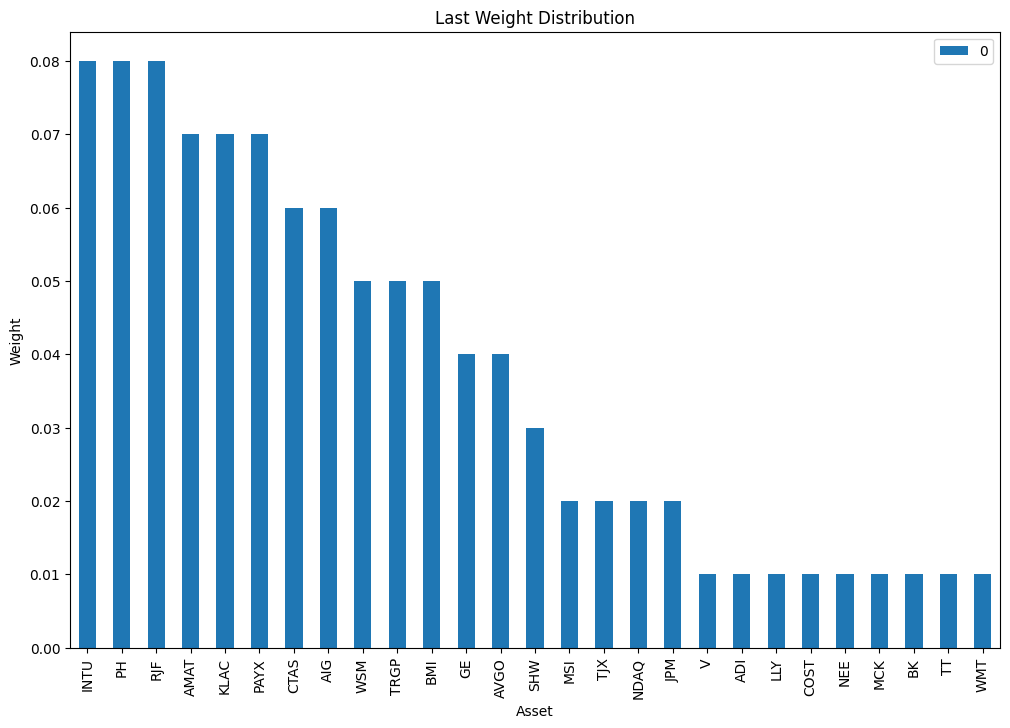

In [9]:
# last weight
weight_df = pd.DataFrame(result['weight_history'])
print([result['last_weights']])
lw = pd.DataFrame([result['last_weights']]).T
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
lw.plot(kind='bar', ax=plt.gca())
plt.title('Last Weight Distribution')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.show()


In [ ]:
print(result['last_weights'])

In [ ]:
weight_df = pd.DataFrame(result['weight_history'])
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Create sample DataFrame


# Seaborn heatmap - works directly with DataFrame!
plt.figure(figsize=(12, 8))
sns.heatmap(weight_df, 
            annot=False,           # Show values
            fmt='.2f',           # Format to 2 decimal places
            cmap='RdYlBu_r',     # Color map
            center=0.5,          # Center color scale
            square=True,         # Make cells square
            cbar_kws={'label': 'Value'})

plt.title('DataFrame Heatmap (Seaborn)')
plt.tight_layout()
plt.show()

In [ ]:
#!/usr/bin/env python3



def run_portfolio_analysis():
    """Run the main portfolio analysis."""
    print("=" * 60)
    print("PORTFOLIO OPTIMIZATION AND BACKTESTING SYSTEM")
    print("=" * 60)
    
    # Step 1: Create sample data
    # data_dir = create_sample_data()
    data_dir = "price"
    
    # Step 2: Load and validate data
    print("\n1. Loading and validating data...")
    data_loader = DataLoader(data_dir)
    
    # Load all available data
    prices = data_loader.load_prices()
    returns = data_loader.get_returns()
    
    print(f"   Loaded {len(prices.columns)} tickers")
    print(f"   Date range: {prices.index.min()} to {prices.index.max()}")
    print(f"   Total observations: {len(prices)}")
    
    # Validate data
    validator = DataValidator()
    price_issues = validator.validate_price_data(prices)
    returns_issues = validator.validate_returns_data(returns)
    
    print(f"   Data quality score: {validator.get_data_quality_score(prices):.3f}")
    
    if price_issues['warnings']:
        print(f"   Warnings: {len(price_issues['warnings'])}")
    if price_issues['errors']:
        print(f"   Errors: {len(price_issues['errors'])}")
    
    # Step 3: Create optimization strategies
    print("\n2. Creating optimization strategies...")
    
    strategies = [
        StrategyFactory.create('equal_weight'),
        StrategyFactory.create('mean_variance', objective="sortino_ratio"),
        StrategyFactory.create('mean_variance', objective="sharpe_ratio"),
        StrategyFactory.create('random_weight', distribution="dirichlet", seed=42),
        StrategyFactory.create('black_litterman', 
                             prior_method="market_cap", view_method="momentum")
    ]
    
    strategy_names = ["Equal Weight", "Mean-Variance (Sortino)", "Mean-Variance (Sharpe)", "Random Weight", "Black-Litterman"]
    for i, strategy in enumerate(strategies):
        strategy.name = strategy_names[i]
        print(f"   Created: {strategy}")
    
    # Step 4: Set up backtesting
    print("\n3. Setting up backtesting...")
    
    backtester = Backtester(
        initial_capital=100000.0,
        risk_free_rate=0.02,
        transaction_costs=0.001
    )
    
    # Load data into backtester
    backtester.load_data(data_loader)
    
    # Step 5: Run backtests
    print("\n4. Running backtests...")
    
    # Define rebalancing schedule (every 3 months, 1st week, 1st day)
    rebalance_freq = {"months": 3, "weeks": 1, "days": 1}
    
    # Run backtests for all strategies
    results = backtester.run_multiple_backtests(
        strategies=strategies,
        rebalance_freq=rebalance_freq,
        start_date='2021-01-01',  # Start from 2021 to have enough history
        end_date='2023-12-31'
    )
    
    print(f"   Completed backtests for {len(results)} strategies")
    
    # Step 6: Compare strategies
    print("\n5. Comparing strategy performance...")
    
    comparison = backtester.compare_strategies()
    print("\nStrategy Performance Comparison:")
    print("-" * 80)
    print(comparison.round(3).to_string(index=False))
    
    # Step 7: Generate detailed analysis
    print("\n6. Detailed strategy analysis...")
    
    for strategy_name, result in results.items():
        metrics = result['performance_metrics']
        summary = result['summary']
        
        print(f"\n{strategy_name}:")
        print(f"  Total Return: {metrics.get('total_return', 0):.2%}")
        print(f"  Annualized Return: {metrics.get('annualized_return', 0):.2%}")
        print(f"  Volatility: {metrics.get('volatility', 0):.2%}")
        print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.3f}")
        print(f"  Sortino Ratio: {metrics.get('sortino_ratio', 0):.3f}")
        print(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
        print(f"  Number of Transactions: {summary.get('num_transactions', 0)}")
        print(f"  Total Transaction Costs: ${summary.get('total_transaction_costs', 0):.2f}")
    
    # Step 8: Export results
    print("\n7. Exporting results...")
    
    # Export comparison to CSV
    comparison.to_csv('strategy_comparison.csv', index=False)
    print("   Exported strategy comparison to 'strategy_comparison.csv'")
    
    # Export detailed results to JSON
    backtester.export_results('detailed_results.json', format='json')
    print("   Exported detailed results to 'detailed_results.json'")
    
    # Step 9: Generate visualizations
    print("\n8. Generating visualizations...")
    
    try:
        import matplotlib.pyplot as plt
        
        # Plot portfolio values
        plt.figure(figsize=(12, 8))
        for strategy_name, result in results.items():
            if 'portfolio_values' in result and len(result['portfolio_values']) > 0:
                portfolio_series = result['portfolio_values']
                plt.plot(portfolio_series.index, portfolio_series.values, 
                        label=strategy_name, linewidth=2)
        
        plt.title('Portfolio Values Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('portfolio_values.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("   Saved portfolio values plot to 'portfolio_values.png'")
        
        # Plot rolling metrics
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        for i, (strategy_name, result) in enumerate(results.items()):
            rolling_metrics = result['rolling_metrics']
            
            if not rolling_metrics.empty:
                # Rolling Sharpe ratio
                axes[0, 0].plot(rolling_metrics.index, rolling_metrics['rolling_sharpe'], 
                               label=strategy_name, alpha=0.7)
                
                # Rolling volatility
                axes[0, 1].plot(rolling_metrics.index, rolling_metrics['rolling_volatility'], 
                               label=strategy_name, alpha=0.7)
                
                # Rolling return
                axes[1, 0].plot(rolling_metrics.index, rolling_metrics['rolling_return'], 
                               label=strategy_name, alpha=0.7)
                
                # Rolling drawdown
                axes[1, 1].plot(rolling_metrics.index, rolling_metrics['rolling_drawdown'], 
                               label=strategy_name, alpha=0.7)
        
        axes[0, 0].set_title('Rolling Sharpe Ratio')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].set_title('Rolling Volatility')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        axes[1, 0].set_title('Rolling Return')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].set_title('Rolling Drawdown')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        # plt.savefig('rolling_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print("   Saved rolling metrics plot to 'rolling_metrics.png'")
        
    except ImportError:
        print("   Matplotlib not available, skipping visualizations")
    
    # Step 10: Summary
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE")
    print("=" * 60)
    
    # Find best performing strategy
    if not comparison.empty and 'Sharpe Ratio' in comparison.columns:
        best_strategy = comparison.loc[comparison['Sharpe Ratio'].idxmax(), 'Strategy']
        best_sharpe = comparison['Sharpe Ratio'].max()
        
        print(f"\nBest performing strategy (by Sharpe ratio): {best_strategy}")
        print(f"Sharpe ratio: {best_sharpe:.3f}")
    else:
        print(f"\nNo successful backtests completed. Check the error messages above.")
    
    # Clean up temporary data
    import shutil
    shutil.rmtree(data_dir.parent)
    
    print(f"\nTemporary data cleaned up")
    print(f"\nGenerated files:")
    print(f"  - strategy_comparison.csv")
    print(f"  - detailed_results.json")
    print(f"  - portfolio_values.png")
    print(f"  - rolling_metrics.png")





In [ ]:
"""Run the main portfolio analysis."""
print("=" * 60)
print("PORTFOLIO OPTIMIZATION AND BACKTESTING SYSTEM")
print("=" * 60)

# Step 1: Create sample data
# data_dir = create_sample_data()
data_dir = "price"

# Step 2: Load and validate data
print("\n1. Loading and validating data...")
data_loader = DataLoader(data_dir)

# Load all available data
prices = data_loader.load_prices()
returns = data_loader.get_returns()

print(f"   Loaded {len(prices.columns)} tickers")
print(f"   Date range: {prices.index.min()} to {prices.index.max()}")
print(f"   Total observations: {len(prices)}")

# Validate data
validator = DataValidator()
price_issues = validator.validate_price_data(prices)
returns_issues = validator.validate_returns_data(returns)

print(f"   Data quality score: {validator.get_data_quality_score(prices):.3f}")

if price_issues['warnings']:
    print(f"   Warnings: {len(price_issues['warnings'])}")
if price_issues['errors']:
    print(f"   Errors: {len(price_issues['errors'])}")

# Step 3: Create optimization strategies
print("\n2. Creating optimization strategies...")

strategies = [
    StrategyFactory.create('equal_weight'),
    StrategyFactory.create('mean_variance', objective="sortino_ratio"),
    StrategyFactory.create('mean_variance', objective="sharpe_ratio"),
    StrategyFactory.create('random_weight', distribution="dirichlet", seed=42),
    StrategyFactory.create('black_litterman', 
                            prior_method="market_cap", view_method="momentum")
]

strategy_names = ["Equal Weight", "Mean-Variance (Sortino)", "Mean-Variance (Sharpe)", "Random Weight", "Black-Litterman"]
for i, strategy in enumerate(strategies):
    strategy.name = strategy_names[i]
    print(f"   Created: {strategy}")

# Step 4: Set up backtesting
print("\n3. Setting up backtesting...")

backtester = Backtester(
    initial_capital=100000.0,
    risk_free_rate=0.02,
    transaction_costs=0.001
)

# Load data into backtester
backtester.load_data(data_loader)

# Step 5: Run backtests
print("\n4. Running backtests...")

# Define rebalancing schedule (every 3 months, 1st week, 1st day)
rebalance_freq = {"months": 3, "weeks": 1, "days": 1}

# Run backtests for all strategies
results = backtester.run_multiple_backtests(
    strategies=strategies,
    rebalance_freq=rebalance_freq,
    start_date='2021-01-01',  # Start from 2021 to have enough history
    end_date='2023-12-31'
)

print(f"   Completed backtests for {len(results)} strategies")

# Step 6: Compare strategies
print("\n5. Comparing strategy performance...")

comparison = backtester.compare_strategies()
print("\nStrategy Performance Comparison:")
print("-" * 80)
print(comparison.round(3).to_string(index=False))

# Step 7: Generate detailed analysis
print("\n6. Detailed strategy analysis...")

for strategy_name, result in results.items():
    metrics = result['performance_metrics']
    summary = result['summary']
    
    print(f"\n{strategy_name}:")
    print(f"  Total Return: {metrics.get('total_return', 0):.2%}")
    print(f"  Annualized Return: {metrics.get('annualized_return', 0):.2%}")
    print(f"  Volatility: {metrics.get('volatility', 0):.2%}")
    print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.3f}")
    print(f"  Sortino Ratio: {metrics.get('sortino_ratio', 0):.3f}")
    print(f"  Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
    print(f"  Number of Transactions: {summary.get('num_transactions', 0)}")
    print(f"  Total Transaction Costs: ${summary.get('total_transaction_costs', 0):.2f}")

# Step 8: Export results
print("\n7. Exporting results...")